In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from scipy.sparse import load_npz

X_test = load_npz('data/processed/X_test_tfidf.npz')
y_test = np.load('data/processed/y_test.npy')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import joblib
ml_model = joblib.load('models/logistic_regression.pkl')

y_pred_ml = ml_model.predict(X_test)

acc_ml = accuracy_score(y_test, y_pred_ml)
prec_ml = precision_score(y_test, y_pred_ml)
rec_ml = recall_score(y_test, y_pred_ml)
f1_ml = f1_score(y_test, y_pred_ml)

print("ML model accuracy:", acc_ml)
print(classification_report(y_test, y_pred_ml))


ML model accuracy: 0.5649492800542657
              precision    recall  f1-score   support

           0       0.55      0.68      0.61     15902
           1       0.60      0.45      0.52     16531

    accuracy                           0.56     32433
   macro avg       0.57      0.57      0.56     32433
weighted avg       0.57      0.56      0.56     32433



In [4]:
import torch
import torch.nn as nn

X_test_dense = torch.tensor(X_test.toarray(), dtype=torch.float32)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model_nn = SimpleNN(X_test.shape[1])
model_nn.load_state_dict(torch.load('models/nn_from_scratch.pt', map_location='cpu'))
model_nn.eval()

with torch.no_grad():
    preds_nn = model_nn(X_test_dense).numpy()
    preds_nn = (preds_nn > 0.5).astype(int).reshape(-1)

acc_nn = accuracy_score(y_test, preds_nn)
prec_nn = precision_score(y_test, preds_nn)
rec_nn = recall_score(y_test, preds_nn)
f1_nn = f1_score(y_test, preds_nn)

print("NN accuracy:", acc_nn)
print(classification_report(y_test, preds_nn))


NN accuracy: 0.5640551290352419
              precision    recall  f1-score   support

           0       0.56      0.55      0.55     15902
           1       0.57      0.58      0.58     16531

    accuracy                           0.56     32433
   macro avg       0.56      0.56      0.56     32433
weighted avg       0.56      0.56      0.56     32433



In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("models/transformer")
model = AutoModelForSequenceClassification.from_pretrained("models/transformer")
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
test_df = pd.read_csv('data/processed/test_transformer.csv')

test_df = test_df.sample(500, random_state=42)

texts = test_df['clean_text'].tolist()
labels = test_df['label'].tolist()


In [8]:
def predict_transformer(texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors='pt')
        with torch.no_grad():
            out = model(**enc)
            probs = torch.softmax(out.logits, dim=1)
            preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
    return np.array(preds)

y_pred_tr = predict_transformer(texts)


In [9]:
acc_tr = accuracy_score(labels, y_pred_tr)
prec_tr = precision_score(labels, y_pred_tr)
rec_tr = recall_score(labels, y_pred_tr)
f1_tr = f1_score(labels, y_pred_tr)

print("Transformer accuracy:", acc_tr)
print(classification_report(labels, y_pred_tr))


Transformer accuracy: 0.886
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       260
           1       0.91      0.85      0.88       240

    accuracy                           0.89       500
   macro avg       0.89      0.88      0.89       500
weighted avg       0.89      0.89      0.89       500



Porównanie wyników

In [10]:
results = pd.DataFrame({
    "model": ["LogisticRegression", "NN_from_scratch", "Transformer"],
    "accuracy": [acc_ml, acc_nn, acc_tr],
    "precision": [prec_ml, prec_nn, prec_tr],
    "recall": [rec_ml, rec_nn, rec_tr],
    "f1": [f1_ml, f1_nn, f1_tr]
})

results


,model,accuracy,precision,recall,f1
0,LogisticRegression,0.564949,0.596247,0.453633,0.515254
1,NN_from_scratch,0.564055,0.571301,0.579699,0.575469
2,Transformer,0.886000,0.910314,0.845833,0.876890


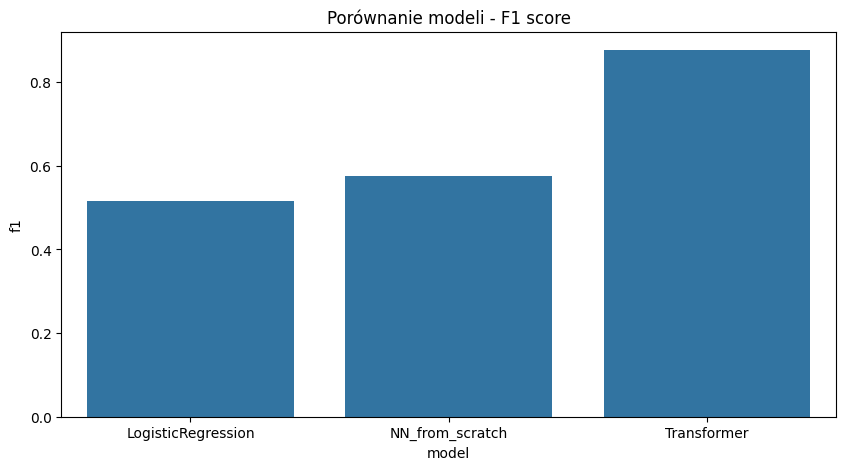

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x="model", y="f1")
plt.title("Porównanie modeli - F1 score")
plt.show()


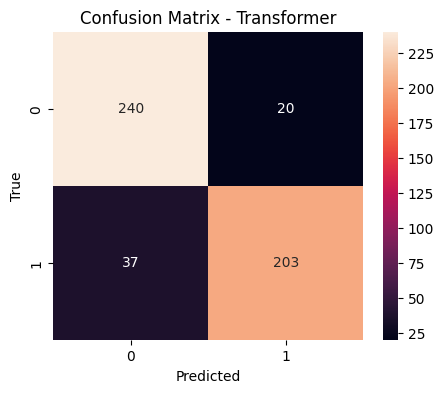

In [12]:
cm = confusion_matrix(labels, y_pred_tr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Transformer")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
